In [1]:
import os
import cv2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cppredictor
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

In [2]:
# Config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE = 'cuda'

# Build predictor
predictor = cppredictor.build_conformal_predictor(cfg)
predictor.load_calibration("/home/RCNN/detectron2/calib.json")  # Load calibration values

Loaded calibration data


In [3]:
# Load test image
test_img_path = "/home/datasets/coco/val2017/000000000785.jpg"
test_json_file = "/home/datasets/coco/annotations/instances_val2017.json"
image = cv2.imread(test_img_path)

In [4]:
# Predict and conformalize
outputs = predictor(image)
predictor.conformalize(outputs["instances"])

# Visualization
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Draw conformal region boxes
conformal_regions = outputs["instances"].conformal_region
output_img = out.get_image()[:, :, ::-1].copy()  # <--- 이 줄에 .copy() 추가
for region in conformal_regions:
    pt1 = (int(region["x1_min"]), int(region["y1_min"]))
    pt2 = (int(region["x2_max"]), int(region["y2_max"]))
    cv2.rectangle(output_img, pt1, pt2, (0, 255, 0), 1)
    pt3 = (int(region["x1_max"]), int(region["y1_max"]))
    pt4 = (int(region["x2_min"]), int(region["y2_min"]))
    cv2.rectangle(output_img, pt3, pt4, (0, 255, 0), 1)  

/opt/anaconda3/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# Load ground-truth boxes using pycocotools
coco = COCO(test_json_file)
file_name = os.path.basename(test_img_path)
img_id = None
for k, v in coco.imgs.items():
    if v["file_name"].endswith(file_name):
        img_id = k
        break
if img_id is None:
    raise ValueError(f"Image ID not found for {file_name}")
ann_ids = coco.getAnnIds(imgIds=img_id)
"""
    # Draw ground-truth boxes in red
    for ann in anns:
        bbox = ann["bbox"]  # format: [x, y, width, height]
        x1 = int(bbox[0])
        y1 = int(bbox[1])
        x2 = x1 + int(bbox[2])
        y2 = y1 + int(bbox[3])
        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 1)
"""
# Save or display
#cv2.imshow("Conformal Prediction Visualization", output_img)
#cv2.waitKey(0)  # Wait for a key press
#cv2.destroyAllWindows()  # Close the window when a key is pressed
#cv2.imwrite("output_conformal.jpg", output_img)
#print("Saved visualization to output_conformal.jpg")

loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


'\n    # Draw ground-truth boxes in red\n    for ann in anns:\n        bbox = ann["bbox"]  # format: [x, y, width, height]\n        x1 = int(bbox[0])\n        y1 = int(bbox[1])\n        x2 = x1 + int(bbox[2])\n        y2 = y1 + int(bbox[3])\n        cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 1)\n'

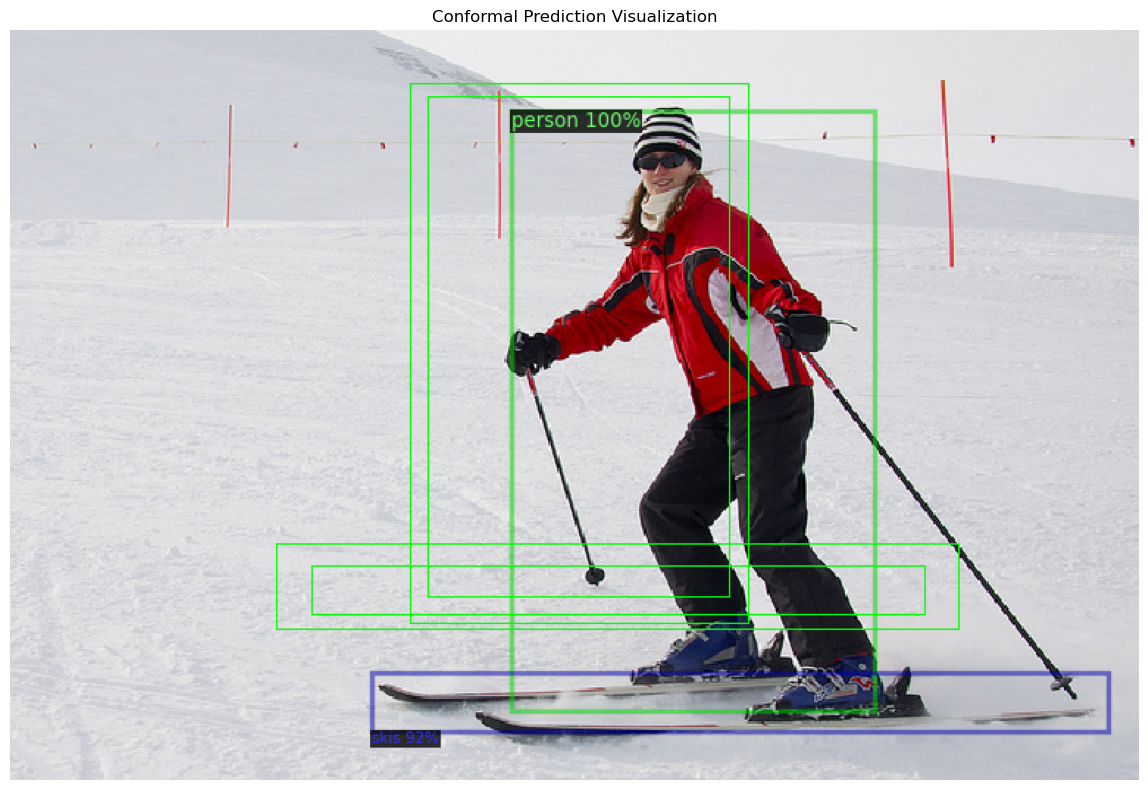

In [6]:
# Display the image using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis('off')
plt.title("Conformal Prediction Visualization")
plt.tight_layout()
plt.show()

# Optionally, save the image
# plt.savefig("output_conformal.jpg", bbox_inches='tight', dpi=150)
